In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
(xtrain,ytrain),(xtest,ytest)= tf.keras.datasets.mnist.load_data()

In [3]:
xtrain.shape

(60000, 28, 28)

In [4]:
xtest.shape

(10000, 28, 28)

In [5]:
ytest.shape

(10000,)

In [6]:
ytrain.shape

(60000,)

In [7]:
ytrain[0]

5

In [8]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2415932659669057736
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12238322266
locality {
  bus_id: 1
}
incarnation: 10487274271565596317
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7577659264
locality {
  bus_id: 1
}
incarnation: 13435590333069415171
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [9]:
ytest

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

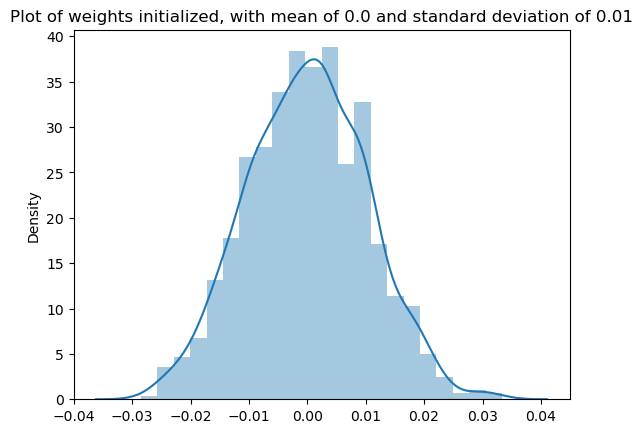

In [11]:
def initialize_weights(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

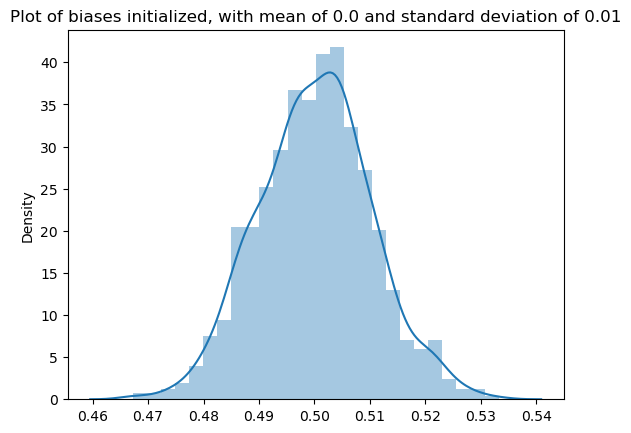

In [12]:
def initialize_bias(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)


# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [13]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [14]:
import cv2
import numpy as np

# Assuming 'image' is your NumPy array representing the image
# and 'scale_factor' is the factor by which you want to upscale the image.
scale_factor=4
# Upscale using cv2.resize
upscaled_images = np.empty((60000,112,112))

for i, image in enumerate(xtrain):
    upscaled_images[i] = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

In [15]:
xtrain.shape

(60000, 28, 28)

In [16]:
upscaled_images.shape

(60000, 112, 112)

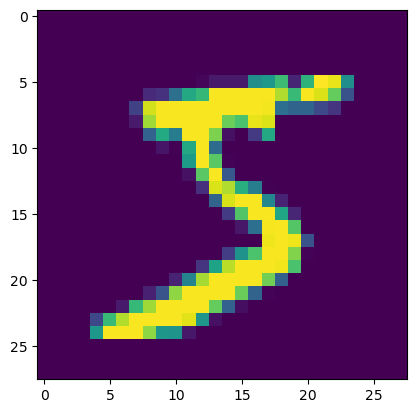

In [17]:
plt.imshow(xtrain[0])

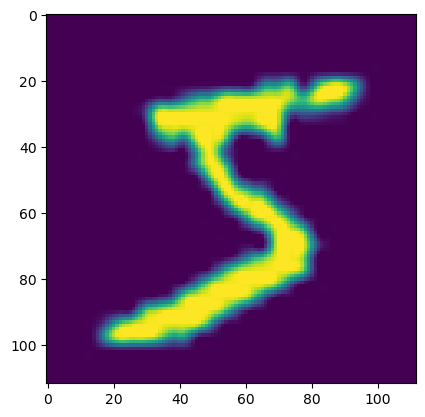

In [18]:
plt.imshow(upscaled_images[0])

In [19]:
model = get_siamese_model((112,112, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [20]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [21]:
upscaled_images.shape

(60000, 112, 112)

In [22]:
def make(batch_size):
    X = upscaled_images
    Y = ytrain
    n_examples,w,h = X.shape
    n_classes = np.unique(ytrain)
    
    # categories = rng.choice(n_classes,size=(batch_size,),replace=True)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    # category = categories[i]
    for i in range(batch_size):
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
                #pick images of same class for 1st half, different for 2nd
        if ytrain[idx_1] == ytrain[idx_2]:
            targets[i] = 1  
        else: 
                    #add a random number to the category modulo n classes to ensure 2nd image has
                    # ..different category
            # category_2 = (category + rng.randint(0,9)) % n_classes
            targets[i] = 0
        pairs[1][i,:,:,:] = X[idx_2].reshape(w, h,1)
    return pairs, targets

In [23]:
p,t = make(8)

In [24]:
p[0].shape

(8, 112, 112, 1)

In [25]:
p[1].shape

(8, 112, 112, 1)

In [26]:
t

array([0., 0., 0., 0., 0., 0., 0., 0.])

[0. 0. 0. 0. 0. 0. 0. 0.]


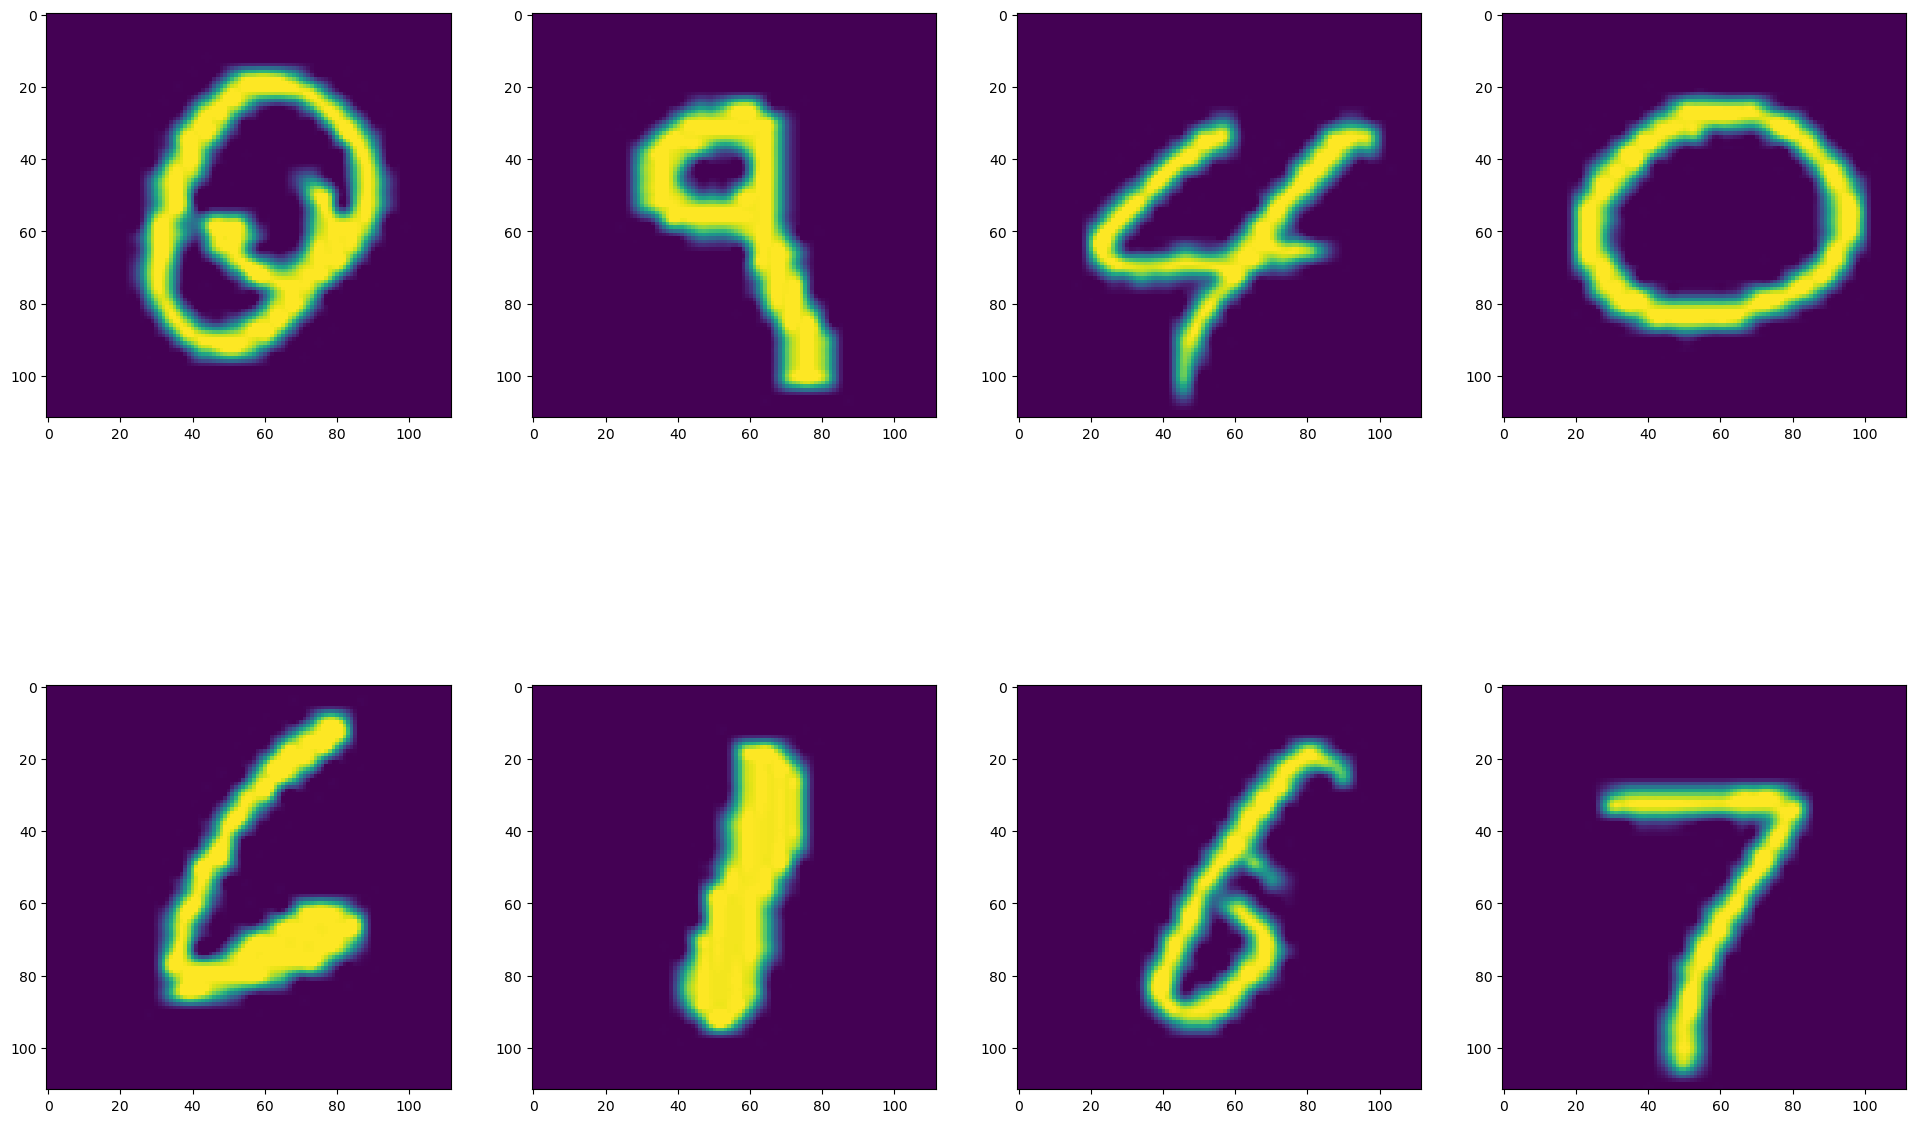

In [27]:
p,t = make(8)
fig,axs = plt.subplots(2,4,figsize=(24,16))
for i in range(0,4):
    axs[0,i].imshow(p[0][i,:,:,0])
    axs[1,i].imshow(p[1][i,:,:,0])
    
print(t)

In [28]:
def generate(batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = make(batch_size)
            yield (pairs, targets)

In [29]:
def test_oneshot(model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass

In [30]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 5000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
training_loss = []
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    inputs,targets = make(batch_size)
    loss=model.train_on_batch(inputs,targets)
    training_loss.append(loss)
    if (i%1000==0 or i==1):
        print(f"Iteration {i} Loss: {loss}\n-------------") 
#     if i % evaluate_every == 0:
#         print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
#         val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
#         if val_acc >= best:
#             print("Current best: {0}, previous best: {1}".format(val_acc, best))
#             print("Saving weights to: {0} \n".format(weights_path))
#             model.save_weights(weights_path_2)
#             best=val_acc
    
    # if i % loss_every == 0:
    #     print("iteration {}, training loss: {:.2f},".format(i,loss))


Starting training process!
-------------------------------------
Iteration 1 Loss: 4.695483207702637
-------------
Iteration 1000 Loss: 0.5746981501579285
-------------
Iteration 2000 Loss: 0.3206126093864441
-------------
Iteration 3000 Loss: 0.15029442310333252
-------------
Iteration 4000 Loss: 0.10644111037254333
-------------


In [31]:
def make_test_batch(batch_size):
    scale_factor=4
    # Upscale using cv2.resize
    upscaled_xtest = np.empty((10000,112,112))
    for i, image in enumerate(xtest):
        upscaled_xtest[i] = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    X = upscaled_xtest
    Y = ytest
    n_examples,w,h = X.shape
    n_classes = np.unique(ytest)
    
    categories = rng.choice(n_classes,size=(batch_size,),replace=True)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    for i in range(batch_size):
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if ytest[idx_1] == ytest[idx_2]:
                targets[i] = 1  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                #category_2 = (category + rng.randint(0,9)) % n_classes
                targets[i] = 0
            pairs[1][i,:,:,:] = X[idx_2].reshape(w, h,1)
    return pairs, targets
    
ptest,ttest = make_test_batch(8)

[1. 0. 1. 0. 1. 0. 0. 0.]


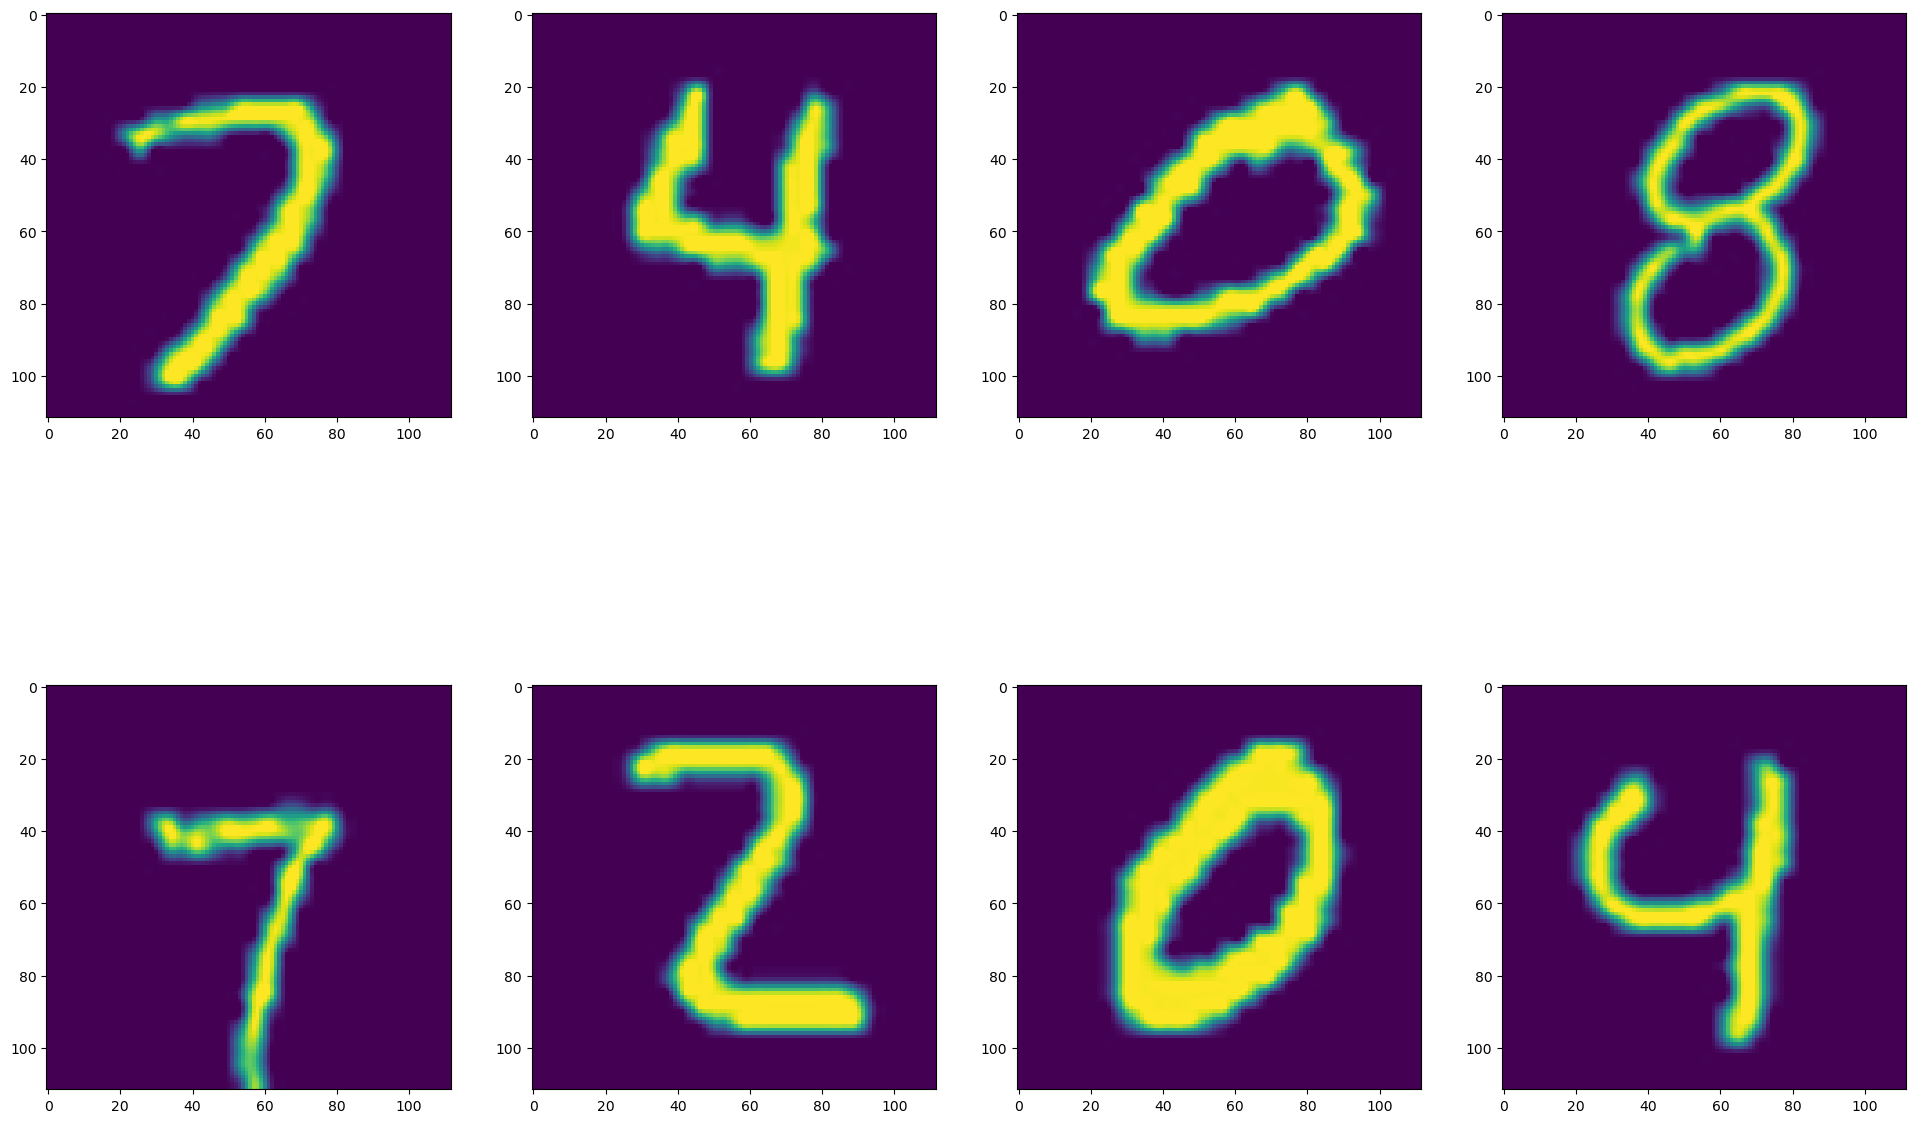

In [32]:
ptest,ttest = make_test_batch(8)
fig,axs = plt.subplots(2,4,figsize=(24,16))
for i in range(0,4):
    axs[0,i].imshow(ptest[0][i,:,:,0])
    axs[1,i].imshow(ptest[1][i,:,:,0])
    
print(ttest)

In [56]:
testing_accuracy = []
batch_size=64
t_start = time.time()
(inputs,targets) = make_test_batch(batch_size)
ypreds=model.predict_on_batch(inputs)
threshold = 0.5
binary_ypreds = np.empty(ypreds.shape)
for i in range(len(ypreds)):
    if ypreds[i]>=threshold:
        binary_ypreds[i] = 1
    else:
        binary_ypreds[i] = 0
print(accuracy_score(binary_ypreds,targets))

0.96875


In [57]:
ypreds

array([[1.1044185e-04],
       [1.5909443e-04],
       [2.5013594e-03],
       [5.7003589e-04],
       [1.2274982e-05],
       [9.7842395e-01],
       [1.3171807e-04],
       [9.3651943e-05],
       [9.9599540e-01],
       [1.1355781e-05],
       [1.1453261e-03],
       [9.8391265e-01],
       [1.5361878e-03],
       [9.9581689e-01],
       [1.3776301e-04],
       [9.1106549e-04],
       [3.6109484e-06],
       [1.5038016e-04],
       [9.6039556e-04],
       [2.6345332e-04],
       [2.0777748e-04],
       [1.4903684e-04],
       [1.8797979e-04],
       [1.5167151e-04],
       [9.7188031e-06],
       [4.8111055e-05],
       [1.5341032e-04],
       [1.3956530e-03],
       [5.7438201e-06],
       [1.1737493e-03],
       [1.2720315e-04],
       [2.8704226e-04],
       [3.5760764e-03],
       [1.2101980e-03],
       [1.7716338e-05],
       [2.1412368e-04],
       [6.8039154e-03],
       [6.2549085e-04],
       [2.1748357e-03],
       [8.1514663e-05],
       [4.2226541e-04],
       [1.369435

In [58]:
targets

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


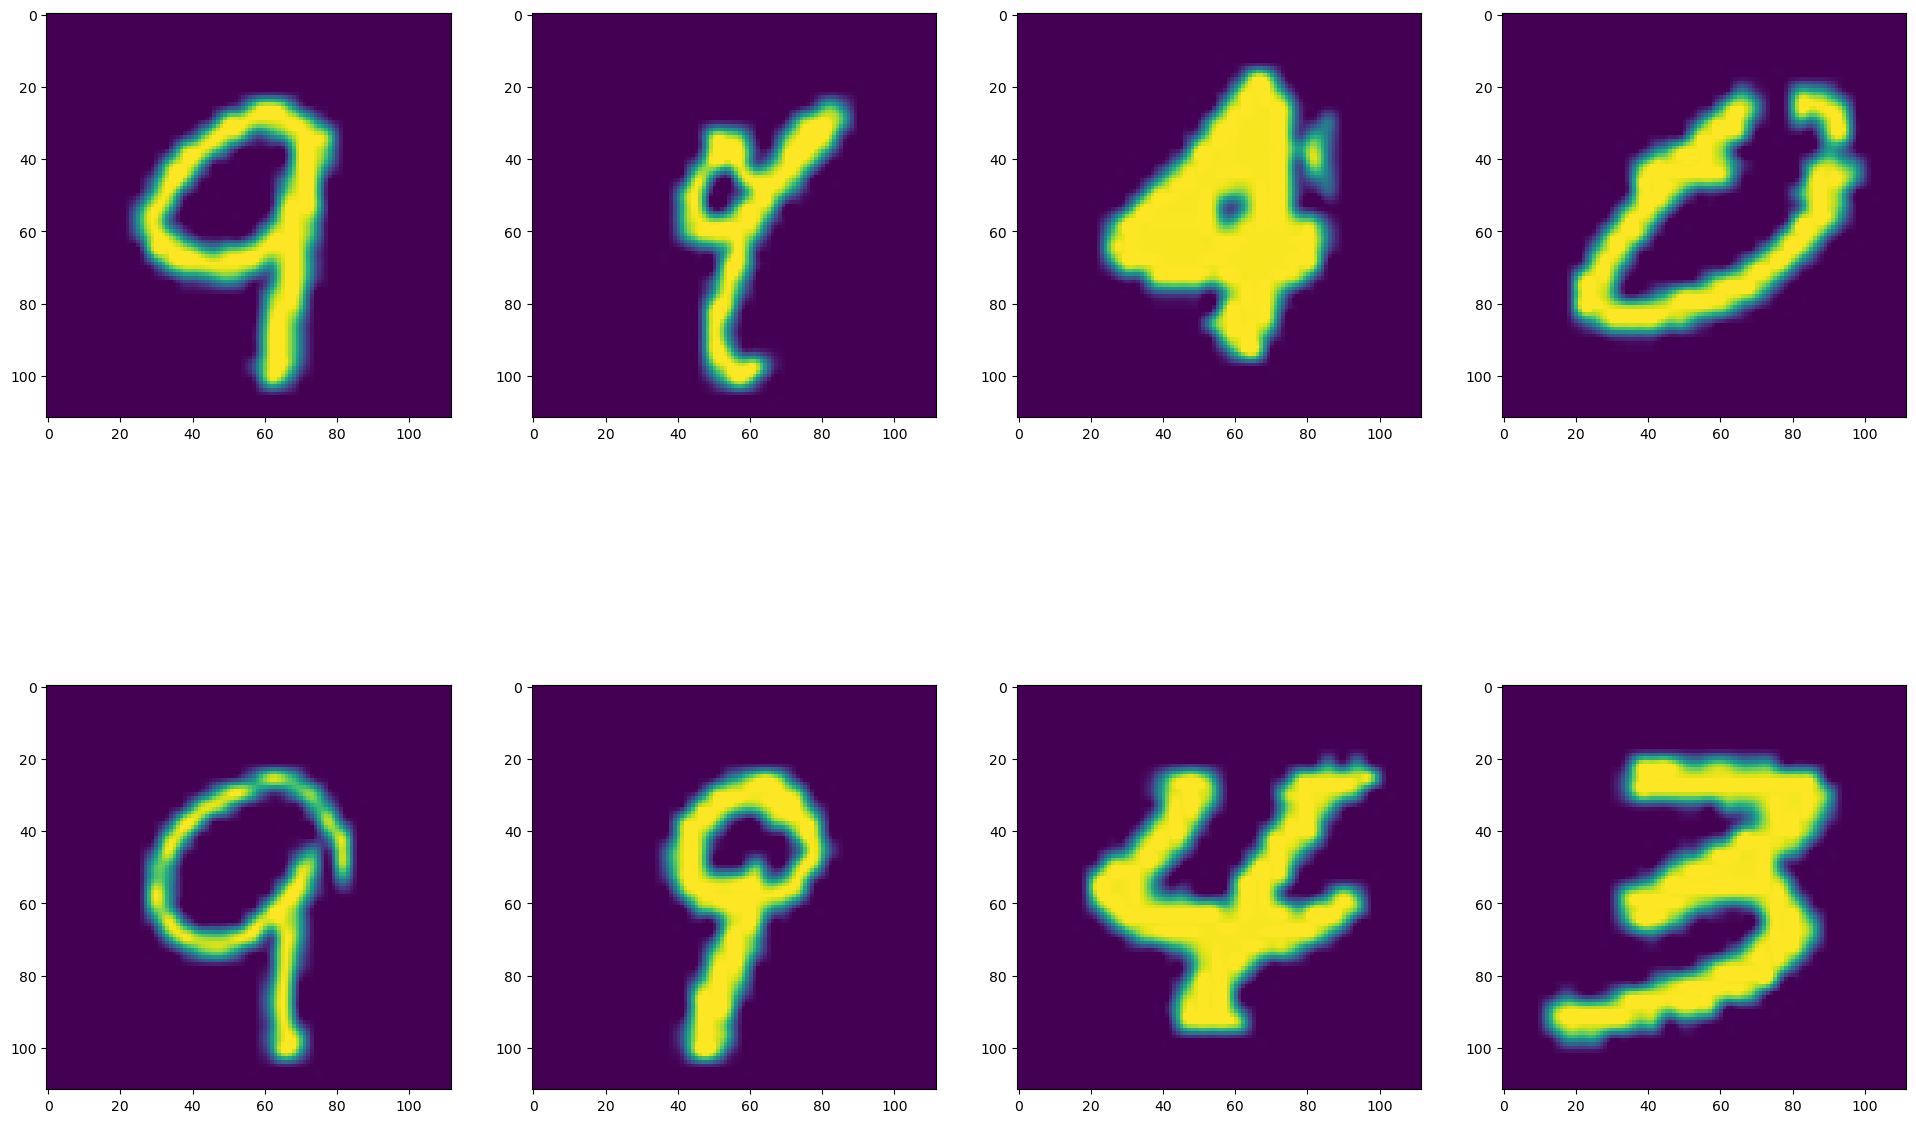

In [55]:
fig,axs = plt.subplots(2,4,figsize=(24,16))
for i in range(0,4):
    axs[0,i].imshow(inputs[0][i,:,:,0])
    axs[1,i].imshow(inputs[1][i,:,:,0])
    
print(targets)

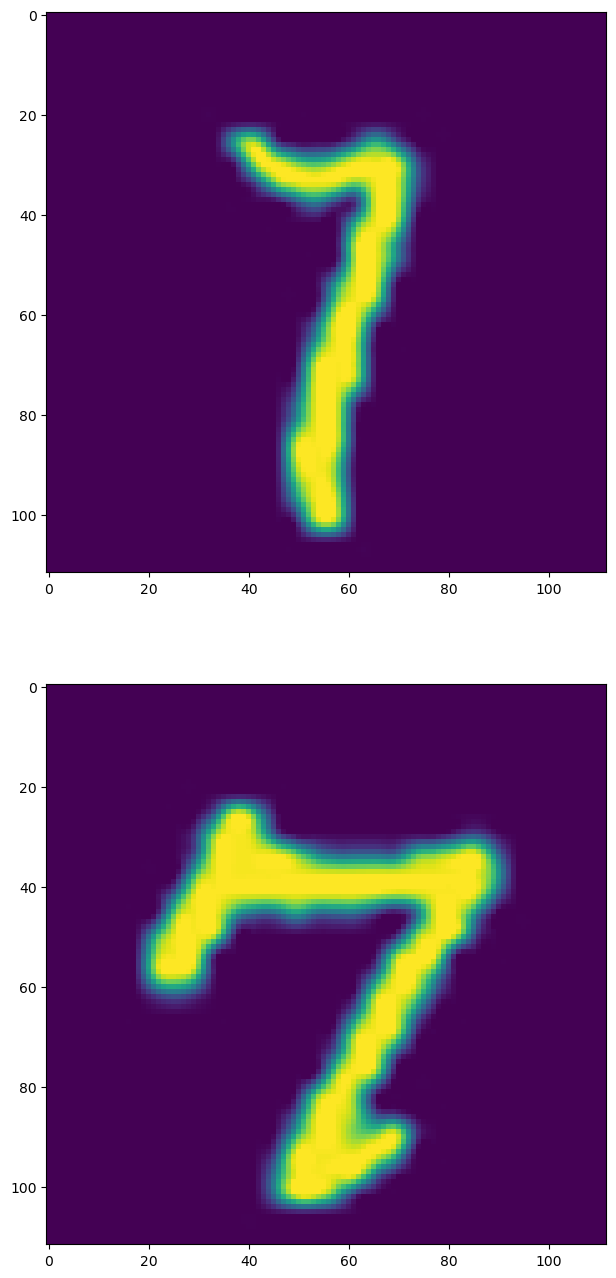

In [61]:
fig,axs = plt.subplots(2,figsize=(24,16))
axs[0].imshow(inputs[0][8,:,:,0])
axs[1].imshow(inputs[1][8,:,:,0])